More knobs to turn:

* (unrealistic) high number of galaxies (10,000+) - defend by claiming possible usability for stars in ellipticals
* (unrealistic) crazy sigma profile (high index) 
* (re-)check whether the code makes sense

More stuff to do:

* create "mean profiles" for Ngal and sigma for given parameters. Draw a lot fo clusters and plot (3D) histograms of the profiles. If there is some information in them, after a lot of draws, they should cluster.
* find a way to plot that narrow image below wider
* what about priors? Are they important here? How to quantify the influence of a prior on the posterior? Or how to confidently show that the data does not contain a significant amount of additional information?

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from numba import jit

% matplotlib inline

plt.rcParams['figure.figsize'] = (12.0, 12.0) 

In [150]:
@jit
def defineAnnuli(r,nAnn):
    return np.append(0.,np.sort(r)[np.linspace(0,len(r)-1,nAnn).astype(int)][1:])

@jit
def labelGalaxies(data,annuli):
    #adds a column to data indicating the galaxy's membership in an annulus
    bla = np.zeros(len(data['r']))
    for i in range(len(annuli)-1):
        bla += i*np.array(np.logical_and(data['r']>annuli[i],data['r']<=annuli[i+1]).astype(int))
    return bla

def galInAnn(data,annuli):
    #calculates the number of galaxies in all the annuli
    return np.array([(data['annuli']==i).sum() for i in range(len(annuli)-1)])

def sigInAnn(data,annuli):
    return [np.std(data['vobs'][data['annuli']==i],ddof=1) for i in range(len(annuli)-1)]


In [151]:
@jit
def defineShellRadii(nTot=1000.,rOut=1000.,nAnn=10,k=3):
    radii = np.array([1.])
    if k==3:
        nu0 = nTot/(4*np.pi*np.log(rOut))
        c = nTot/(nAnn*4*np.pi*nu0)
    else:
        nu0 = nTot*(3.-k)/(4*np.pi*(rOut**(3.-k)-1.))
        c = (3-k)*nTot/(4*np.pi*nu0*nAnn)
        
    for i in range(nAnn):
        if k==3:
            radii = np.append(radii,np.exp(c+np.log(radii[i])))
        else:
            radii = np.append(radii,(c+radii[i]**(3-k))**(1./(3-k)))
    return radii

defineShellRadii()

@jit
def nuProfile(Ntot,radii,k=2.9):
    nu0 = Ntot / (4.*np.pi*(nuInt(radii[-1], k)-nuInt(radii[0], k)))
    print nu0
    #print 'nu0:' ,nu0
    return (nu0*(nuInt(radii[1:],k) - nuInt(radii[:-1],k))).astype(int)

@jit
def sigmaProfile(radii,sigMax=1000,k=-.2):
    return sigMax*(0.5*(radii[1:]+radii[:-1]))**k

In [152]:
@jit
def createMockData(Ntot=1000,rOut=1000.,nAnn=10,sigMax=1000,kindex=3.,sigmaindex=-0.2): #total Ngals, no of shells
    clusterData = np.zeros((2*Ntot,2))
    counter=0
    radii = defineShellRadii(Ntot,rOut,nAnn,kindex)
    #density = nuProfile(Ntot,radii,k=kindex)
    sig = sigmaProfile(radii,sigMax,k=sigmaindex)
    
    for shell,dens in enumerate(np.random.poisson(Ntot/nAnn*np.ones(nAnn))):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        theta = np.arccos(np.random.uniform(-1,1,dens))
        r = np.power(np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens),1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        #z = r*cosTheta
        
        radius = np.sqrt(np.power(x,2.)+np.power(y,2.))
        #generate velocities
                
        v=sig[shell]*np.random.randn(dens)*np.random.uniform(-1,1,dens)
        
        #replace with vstack,append
        clusterData[counter:counter+dens]=np.hstack((radius.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    #print 'Created mock data with '+str(counter)+' galaxies.'
    return pd.DataFrame(clusterData[:counter],columns=['r','vobs'])

In [153]:
ntot = 1000
rout = 1000
nshells = 7
sigMax = 500
kInd = 2.
sigInd = -0.3

data = createMockData(ntot,rout,nshells,sigMax,kInd,sigInd)

nAnn = 15 #number of desired annuli
annuli = defineAnnuli(data['r'],nAnn+1)

data['annuli']=labelGalaxies(data,annuli)
nData = galInAnn(data,annuli)
sigmaData = sigInAnn(data,annuli)

print nData,sigmaData


[68 67 67 68 67 67 67 68 67 67 67 68 67 67 68] [64.14120369251789, 69.98383527188948, 51.70161106854093, 52.21401782602426, 61.5454999928081, 56.93241181829846, 45.695058924325764, 50.97316434769666, 50.430227270852505, 37.94624903461398, 33.04350881685686, 43.40570583889496, 31.63074066305707, 35.5420446499, 42.60270965636823]


In [154]:
#all log likelihoods

#make a table of log(n!)-s for n=1,...
factorialTable = np.cumsum(np.append(0,[np.log(i) for i in range(1,len(data['r']))]))

def logPriorNu(k):
    #starting gaussian
    nu0 = 3. #mean prior density index
    sigma = 30.
    return 0
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorSigma(k):
    #starting gaussian
    nu0 = -.2 #mean prior sigma index
    sigma = 3.
    return 0.
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorSigmaNorm(k):
    #starting gaussian
    nu0 = 1000 #mean prior sigma index
    sigma = 1000
    return 0.
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logLikelihoodNu(prediction,data):
    return np.sum(data*np.log(prediction)-prediction-factorialTable[data])

def logLikelihoodSigma(vObs,vPred,nPred):
    # distribution of variances is chisq, as shown, for example, at
    # https://onlinecourses.science.psu.edu/stat414/node/174
    return np.sum(np.log(stats.chi2.pdf((nPred-1.)*np.power(vObs,2.)/np.power(vPred,2.),nPred-1)))

def logPosterior(vObs,vPred,nObs,nPred,kInd,sigmaInd,sigmaNorm):
    return logPriorNu(kInd)+logPriorSigma(sigmaInd)+logPriorSigmaNorm(sigmaNorm)+\
           logLikelihoodNu(nPred,nObs)+logLikelihoodSigma(vObs,vPred,nPred)

In [155]:
@jit
def mcmcStep(annuli,kInd,sInd,sigMax):
    mockData = createMockData(len(data['r']),np.amax(data['r']),nshells,sigMax,kInd,sigInd)
    mockData['annuli'] = labelGalaxies(mockData,annuli)
    return galInAnn(mockData,annuli),sigInAnn(mockData,annuli)


In [156]:
%%timeit
mcmcStep(annuli,kInd,sigInd,sigMax)

The slowest run took 92.92 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 29.3 ms per loop


In [173]:
def generateMeanMock(annuli,kInd,sInd,sMaxInd):
    while True:
        dens,sig = mcmcStep(annuli,kInd,sigInd,sigMax)
        if np.isnan(sig).any():
            continue
        else:
            #print dens,sig
            break
    
    while True:
        hlp1,hlp2 = mcmcStep(annuli,kInd,sigInd,sigMax)
        if np.isnan(hlp2).any():
            continue
        else:
            #print hlp1,hlp2
            dens,sig = np.vstack((dens,hlp1)),np.vstack((sig,hlp2))
        if dens.shape[0]>30:
            break
        
    return np.mean(dens,axis=0),np.mean(sig,axis=0)

In [163]:
%%timeit
bla1,bla2 = generateMeanMock(annuli,a,b,sigMax)

1 loops, best of 3: 479 ms per loop


In [200]:
# Set up parameter grids:
npixa = 25
npixb = 120
amin,amax = 1.9,2.1
bmin,bmax = -5.,4.
agrid = np.linspace(amin,amax,npixa)
bgrid = np.linspace(bmin,bmax,npixb)
logprob = np.zeros([npixb,npixa])

# Loop over parameters, computing unnormlized log posterior PDF:
for i,a in enumerate(agrid):
    print 'kInd = '+str(a)
    for j,b in enumerate(bgrid):
        #print 'kInd,sigInd = '+str(a)+','+str(b)
        nPred,sigPred = generateMeanMock(annuli,a,b,sigMax)
        logprob[j,i] = logPosterior(sigmaData,sigPred,nData,nPred,a,b,sigMax)

# Normalize and exponentiate to get posterior density:
Z = np.max(logprob)
prob = np.exp(logprob - Z)
norm = np.sum(prob)
prob /= norm

kInd = 1.9
kInd = 1.90833333333
kInd = 1.91666666667
kInd = 1.925
kInd = 1.93333333333
kInd = 1.94166666667
kInd = 1.95
kInd = 1.95833333333
kInd = 1.96666666667
kInd = 1.975
kInd = 1.98333333333
kInd = 1.99166666667
kInd = 2.0
kInd = 2.00833333333
kInd = 2.01666666667
kInd = 2.025
kInd = 2.03333333333
kInd = 2.04166666667
kInd = 2.05
kInd = 2.05833333333
kInd = 2.06666666667
kInd = 2.075
kInd = 2.08333333333
kInd = 2.09166666667
kInd = 2.1


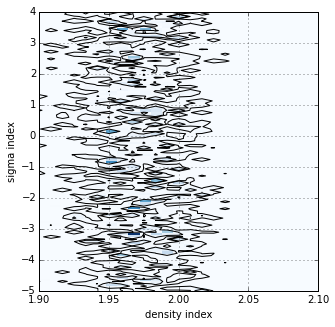

In [201]:
sorted = np.sort(prob.flatten())
C = sorted.cumsum()

# Find the pixel values that lie at the levels that contain
# 68% and 95% of the probability:
lvl68 = np.min(sorted[C > (1.0 - 0.68)])
lvl95 = np.min(sorted[C > (1.0 - 0.95)])

plt.rcParams['figure.figsize'] = (5.0, 5.0) 
plt.imshow(prob, origin='lower', cmap='Blues', interpolation='none',extent=[amin,amax,bmin,bmax],aspect='auto')
plt.contour(prob,[lvl68,lvl95],colors='black',extent=[amin,amax,bmin,bmax])
plt.grid()
plt.xlabel('density index')
plt.ylabel('sigma index')

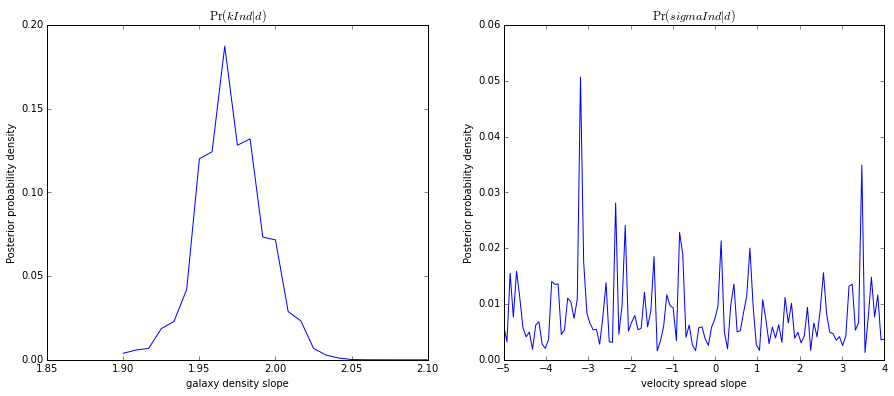

In [202]:
prob_kInd_given_data = np.sum(prob,axis=0) # Approximate the integral as a sum
prob_sigmaInd_given_data = np.sum(prob,axis=1) # Approximate the integral as a sum

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

left = ax[0].plot(agrid, prob_kInd_given_data)
ax[0].set_title('${\\rm Pr}(kInd|d)$')
ax[0].set_xlabel('galaxy density slope')
ax[0].set_ylabel('Posterior probability density')

right = ax[1].plot(bgrid, prob_sigmaInd_given_data)
ax[1].set_title('${\\rm Pr}(sigmaInd|d)$')
ax[1].set_xlabel('velocity spread slope')
ax[1].set_ylabel('Posterior probability density')

In [203]:
def compress_1D_pdf(x,pr,ci=68,dp=1):
    
    # Interpret credible interval request:
    low  = (1.0 - ci/100.0)/2.0    # 0.16 for ci=68
    high = 1.0 - low               # 0.84 for ci=68

    # Find cumulative distribution and compute percentiles:
    cumulant = pr.cumsum()
    pctlow = x[cumulant>low].min()
    median = x[cumulant>0.50].min()
    pcthigh = x[cumulant>high].min()
    
    # Convert to error bars, and format a string:
    errplus = np.abs(pcthigh - median)
    errminus = np.abs(median - pctlow)
    
    report = "$ "+str(round(median,dp))+"^{+"+str(round(errplus,dp))+"}_{-"+str(round(errminus,dp))+"} $"
    
    return report

print("kInd = ",compress_1D_pdf(agrid,prob_kInd_given_data,ci=68,dp=2))

print("sigmaInd = ",compress_1D_pdf(bgrid,prob_sigmaInd_given_data,ci=68,dp=2))

('kInd = ', '$ 1.97^{+0.03}_{-0.02} $')
('sigmaInd = ', '$ -0.92^{+3.48}_{-2.5} $')


In [204]:
np.savetxt('prob.txt',prob)